<a href="https://colab.research.google.com/github/sekunder/NMA_Project/blob/master/Orientation_Selectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Data retrieval and loading and Matplotlib import
#get the data
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

#load it into a dict
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

#import pyplot and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* dat['sresp']: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* dat['run']: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* dat['istim']: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* dat['stat']: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.
* dat['stat'][k]['med']: 1 by 2, the position of each neuron k in tissue, in pixels, at a resolution of ~2um/pix. 
* dat['u_spont']: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* dat['v_spont']: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* dat['u_spont'] @ dat['v_spont']: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.

In [ ]:
#@ Store (x,y) positions of each neuron
tp = np.zeros(((dat['sresp'].shape[1]),2))
for k in range(dat['sresp'].shape[1]):
    tp[k,:] = np.array([dat['stat'][k]['xpix'].mean(),dat['stat'][k]['ypix'].mean()])

In [ ]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 

# Number of components to use
n_cmp = 20

Z = zscore(dat['sresp'], axis=1)
p = PCA(n_components = n_cmp)
p.fit_transform(Z.T)
X = p.components_@Z

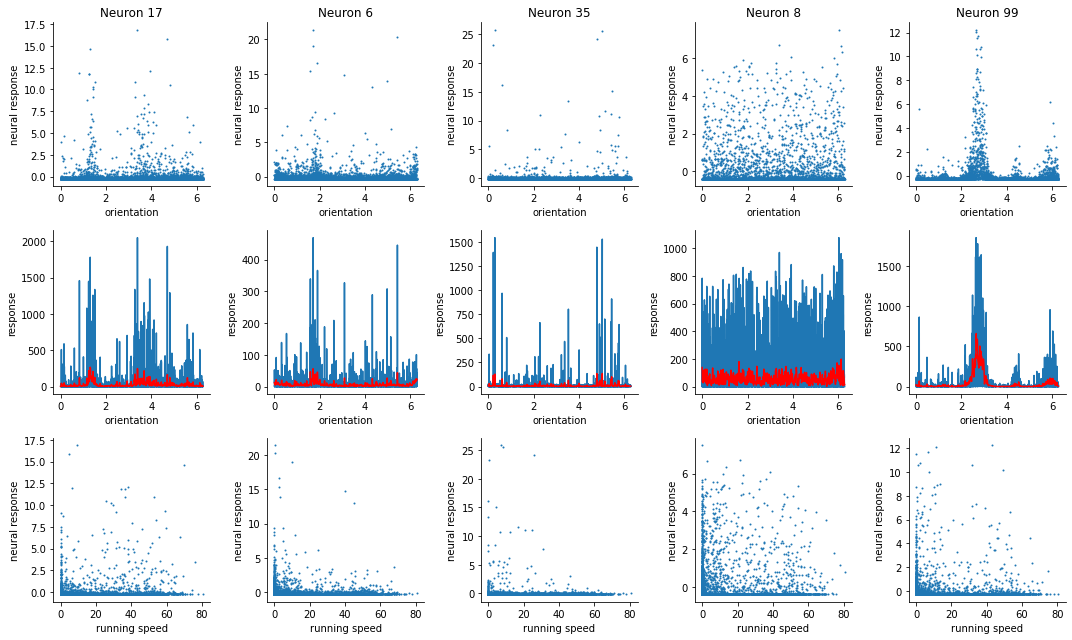

In [31]:
# Starting to play around with individual neuron tuning.
# Ideally, we can find some way to characterize neurons by how "selective" they are
# for orientation, since that's a simple thing to compare between stimuli.
from scipy.ndimage import gaussian_filter1d

R = dat['sresp']
isort = np.argsort(dat['istim'])
R_sorted = R[:,isort]

favorite_neurons = [17, 6, 35, 8, 99]
# favorite_neurons = [8, 99]
plt.figure(figsize=(15,9))
for i, n in enumerate(favorite_neurons):
  ax = plt.subplot(3,len(favorite_neurons),i+1)
  plt.scatter(dat['istim'], Z[n,:], s=1)
  ax.set(xlabel = 'orientation', ylabel = 'neural response', title='Neuron %d'%n)

  ax = plt.subplot(3,len(favorite_neurons), i+1 + len(favorite_neurons))
  plt.plot(sorted(dat['istim']), R_sorted[n,:])
  filtered = gaussian_filter1d(R_sorted[n,:], 5)
  plt.plot(sorted(dat['istim']), filtered, c="red")
  ax.set(xlabel="orientation", ylabel="response")

  ax = plt.subplot(3, len(favorite_neurons), i+1 + 2*len(favorite_neurons))
  plt.scatter(dat['run'], Z[n,:], s=1)
  ax.set(xlabel = 'running speed', ylabel='neural response')

In [ ]:
O = R @ dat['istim']
print(O[favorite_neurons])
print("Max stimulus:",max(dat['istim']),"Min Stimulus:",min(dat['istim']))


[428075.95600185  87455.27053312 138307.38345101 778508.33641098
 569803.66031687]
Max stimulus: 6.282404857491223 Min Stimulus: 0.0006091591363192009
